In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from replayers import ABTestReplayer, EpsilonGreedyReplayer, ThompsonSamplingReplayer, UCBReplayer, GradientBanditReplayer, LinUCBReplayer

# **Pre-Processing**

In [ ]:
df_movies = pd.read_csv('movies.dat', encoding='ISO-8859-1', sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'])
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_movies.isna().sum()

,0
MovieID,0
Title,0
Genres,0


In [ ]:
df_movies.shape

(3883, 3)

In [ ]:
df_movies['Genres'] = df_movies['Genres'].str.split('|')
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
df_movies.isna().sum()

,0
MovieID,0
Title,0
Genres,0


In [ ]:
df_ratings = pd.read_csv('ratings.dat', encoding='ISO-8859-1', sep='::', engine='python', header=None, names=['UserID','MovieID','Rating','Timestamp'])
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
df_ratings.isna().sum()

,0
UserID,0
MovieID,0
Rating,0
Timestamp,0


In [ ]:
df_ratings.shape

(1000209, 4)

In [ ]:
df_users = pd.read_csv('users.dat', encoding='ISO-8859-1', sep='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zipcode'])
df_users.head()

,UserID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
df_users.isna().sum()

,0
UserID,0
Gender,0
Age,0
Occupation,0
Zipcode,0


In [ ]:
df_users.shape

(6040, 5)

In [ ]:
df_users.replace({'Occupation':{0: "other",
                             1: "academic/educator",
                             2: "artist",
                             3: "clerical/admin",
                             4: "college/grad student",
                             5: "customer service",
                             6: "doctor/health care",
                             7: "executive/managerial",
                             8: "farmer",
                             9: "homemaker",
                             10: "k-12 student",
                             11: "lawyer",
                             12: "programmer",
                             13: "retired",
                             14: "sales/marketing",
                             15: "scientist",
                             16: "self-employed",
                             17: "technician/engineer",
                             18: "tradesman/craftsman",
                             19: "unemployed",
                             20: "writer"}}, inplace=True)

In [ ]:
df_users.replace({'Age':{1:  "Under 18",
                      18:  "18-24",
                      25:  "25-34",
                      35:  "35-44",
                      45:  "45-49",
                      50:  "50-55",
                      56:  "56 & Above"}}, inplace=True)

In [ ]:
df_users.head()

,UserID,Gender,Age,Occupation,Zipcode
0,1,F,Under 18,k-12 student,48067
1,2,M,56 & Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [ ]:
import re
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return int(match.group(1))
    else:
        return np.nan

In [ ]:
def remove_year(title):
    match = re.search(r'\(\d{4}\)', title)
    if match:
        return title[:match.start()].strip()
    return title

In [ ]:
df_movies['Year'] = df_movies['Title'].apply(extract_year)
df_movies['Title'] = df_movies['Title'].apply(remove_year)
df_movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
df_movies.isna().sum()

,0
MovieID,0
Title,0
Genres,0
Year,0


In [ ]:
df_temp = pd.merge(df_movies,df_ratings,how='inner',on='MovieID')
df_temp.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474


In [ ]:
df_final = pd.merge(df_temp,df_users,how='inner',on='UserID')
df_final.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zipcode
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370


In [ ]:
n_unique_movies = df_final['MovieID'].nunique()
print(f"Number of unique movie IDs in df_final: {n_unique_movies}")

Number of unique movie IDs in df_final: 3706


In [ ]:
df_final.isna().sum()

,0
MovieID,0
Title,0
Genres,0
Year,0
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0


In [ ]:
df_final.shape

(1000209, 11)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  object
 3   Year        1000209 non-null  int64 
 4   UserID      1000209 non-null  int64 
 5   Rating      1000209 non-null  int64 
 6   Timestamp   1000209 non-null  int64 
 7   Gender      1000209 non-null  object
 8   Age         1000209 non-null  object
 9   Occupation  1000209 non-null  object
 10  Zipcode     1000209 non-null  object
dtypes: int64(5), object(6)
memory usage: 83.9+ MB


# **SVD and KMeans**

In [ ]:
matrix = pd.pivot_table(df_final,index='UserID',columns='MovieID',values='Rating',aggfunc='mean')

In [ ]:
matrix.fillna(matrix.mean(),inplace=True)

In [ ]:
matrix.head()

In [ ]:
matrix.isna().sum()

In [ ]:
U, sigma, VT = np.linalg.svd(matrix.to_numpy(), full_matrices=False)

p = 20

U_p = U[:, :p]
sigma_p = np.diag(sigma[:p])
VT_p = VT[:p, :]

# Reconstruct the train matrix using the top p singular values
reconstructed_matrix = np.dot(U_p, np.dot(sigma_p, VT_p))

print(f"Reconstructed train matrix shape: {reconstructed_matrix.shape}")


Reconstructed train matrix shape: (6040, 3706)


In [ ]:
null_values = np.isnan(reconstructed_matrix).sum()
print(f"Number of null values in reconstructed_matrix: {null_values}")

Number of null values in reconstructed_matrix: 0


In [ ]:
reconstructed_train_matrix, reconstructed_test_matrix = train_test_split(reconstructed_matrix, test_size=0.1, random_state=42)

print("Reconstructed Train matrix shape:", reconstructed_train_matrix.shape)
print("Reconstructed Test matrix shape:", reconstructed_test_matrix.shape)

Reconstructed Train matrix shape: (5436, 3706)
Reconstructed Test matrix shape: (604, 3706)


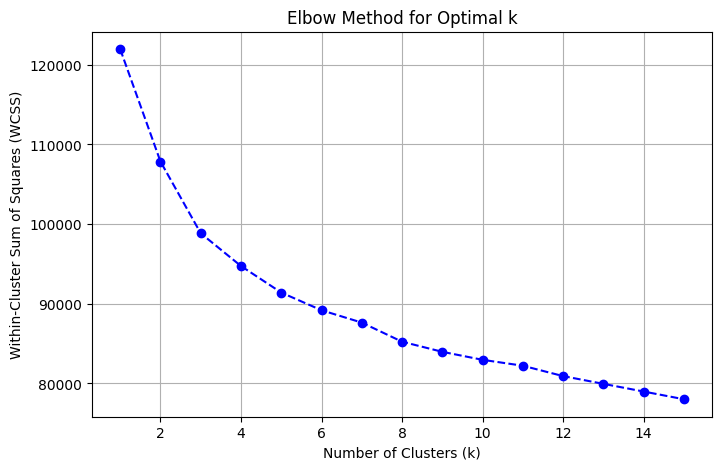

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
max_k = 15

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(reconstructed_train_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()


In [ ]:
optimal_clusters = 3

kmeans = KMeans(n_clusters= optimal_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(reconstructed_train_matrix)

reconstructed_train_matrix = pd.DataFrame(reconstructed_train_matrix)

reconstructed_train_matrix.columns = matrix.columns

reconstructed_train_matrix['Cluster'] = cluster_labels

cluster_means = reconstructed_train_matrix.groupby('Cluster').mean()

print(cluster_means.head())

MovieID      1         2         3         4         5         6         7     \
Cluster                                                                         
0        4.143992  3.197926  3.017977  2.730660  3.007888  3.877920  3.412624   
1        3.776771  2.939832  2.854947  2.659192  2.869532  3.688331  3.263123   
2        4.370089  3.373384  3.098043  2.755209  3.072198  3.999245  3.467614   

MovieID      8         9         10    ...      3943      3944      3945  \
Cluster                                ...                                 
0        3.014477  2.655763  3.534871  ...  3.051741  2.111232  1.488461   
1        2.984244  2.609285  3.241368  ...  3.046347  2.109426  1.481047   
2        3.033373  2.698265  3.773064  ...  3.061076  2.110851  1.491016   

MovieID      3946      3947      3948      3949      3950      3951      3952  
Cluster                                                                        
0        2.259206  3.472938  3.635076  4.114795  3.66

In [ ]:
import numpy as np

def predict_test_matrix(test_matrix, cluster_means, cluster_labels):
    predictions = []
    for user_index in range(test_matrix.shape[0]):
        user_vector = test_matrix[user_index, :]

        min_distance = float('inf')
        best_cluster = -1

        for cluster_id in range(len(cluster_means)):
            cluster_mean = cluster_means.iloc[cluster_id].values
            distance = np.linalg.norm(user_vector - cluster_mean)  # Euclidean distance

            if distance < min_distance:
                min_distance = distance
                best_cluster = cluster_id

        if best_cluster == -1:
            best_cluster = 0

        predictions.append(cluster_means.iloc[best_cluster].values)

    return np.array(predictions)

predicted_test_values = predict_test_matrix(reconstructed_test_matrix, cluster_means, cluster_labels)
print(predicted_test_values)
print(np.isnan(predicted_test_values).sum())

[[3.77677125 2.93983164 2.85494699 ... 3.65828528 3.89198344 3.71003487]
 [4.14399207 3.19792619 3.01797731 ... 3.66671986 3.90009924 3.78122099]
 [4.14399207 3.19792619 3.01797731 ... 3.66671986 3.90009924 3.78122099]
 ...
 [4.14399207 3.19792619 3.01797731 ... 3.66671986 3.90009924 3.78122099]
 [4.14399207 3.19792619 3.01797731 ... 3.66671986 3.90009924 3.78122099]
 [4.14399207 3.19792619 3.01797731 ... 3.66671986 3.90009924 3.78122099]]
0


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def compute_rmse(true_ratings, predicted_ratings):
    mask = ~np.isnan(true_ratings)
    true_values = true_ratings[mask]
    predicted_values = predicted_ratings[mask]
    return np.sqrt(mean_squared_error(true_values, predicted_values))

predicted_test_values = predict_test_matrix(reconstructed_test_matrix, cluster_means, cluster_labels)

rmse = compute_rmse(reconstructed_test_matrix, predicted_test_values)
print(f"RMSE for reconstructed test matrix: {rmse:.4f}")

RMSE for reconstructed test matrix: 0.0624


In [ ]:
mae = mean_absolute_error(reconstructed_test_matrix, predicted_test_values)
print(f"MAE for reconstructed test matrix: {mae:.4f}")

MAE for reconstructed test matrix: 0.0253


In [ ]:
def recommend_movies(user_index, train_data, predicted_ratings, top_n=5):
    user_ratings = train_data.iloc[user_index]
    unrated_movies = user_ratings[user_ratings.isna()].index

    if len(unrated_movies) == 0:
        print(f"User {user_index} has rated all movies. Recommending top {top_n} movies overall.")
        recommendations = predicted_ratings.sort_values(ascending=False).head(top_n)
    else:
        recommendations = predicted_ratings[unrated_movies].sort_values(ascending=False).head(top_n)

    return recommendations

In [ ]:
user_to_predict = 0

predicted_ratings_series = pd.Series(predicted_test_values[0], index=matrix.columns)

recommendations = recommend_movies(user_to_predict , matrix, predicted_ratings_series, top_n=5)
recommendations

User 0 has rated all movies. Recommending top 5 movies overall.


,0
MovieID,
1830,4.993958
3280,4.993958
3656,4.993958
3607,4.993958
3382,4.993958


# **User-Based Collaborative Filtering without SVD**

In [ ]:
matrix = pd.pivot_table(df_final,index='UserID',columns='MovieID',values='Rating',aggfunc='mean')

In [ ]:
matrix.shape

(6040, 3706)

In [ ]:
matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
matrix.fillna(matrix.mean(),inplace=True)

In [ ]:
#matrix.fillna(4,inplace=True)

In [ ]:
matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
3,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
5,4.146846,3.201141,3.016736,2.729412,3.006757,2.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
train_matrix, test_matrix = train_test_split(matrix, test_size=0.1, random_state=42)
print(train_matrix.shape)
test_matrix.shape

(5436, 3706)


(604, 3706)

In [ ]:
train_matrix = pd.DataFrame(train_matrix)
test_matrix = pd.DataFrame(test_matrix)

In [ ]:
test_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
5530,3.000000,2.000000,3.016736,2.729412,3.006757,3.878723,3.41048,2.000000,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
711,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4924,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2154,4.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
1273,3.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.00000,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
train_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
2407,4.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
747,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,5.000000,3.666667,3.9,3.780928
5427,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2674,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
1091,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
test_matrix_array = test_matrix.to_numpy()

In [ ]:
test_matrix_array.shape

(604, 3706)

In [ ]:
train_matrix_array = train_matrix.to_numpy()

In [ ]:
train_matrix_array.shape

(5436, 3706)

In [ ]:
train_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
2407,4.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
747,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,5.000000,3.666667,3.9,3.780928
5427,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2674,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
1091,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
similarities=[]
for i in range(test_matrix_array.shape[0]):
  test_matrix_row_mean = test_matrix.iloc[i].mean()
  test_matrix_row_centered = test_matrix.iloc[i] - test_matrix_row_mean
  train_matrix_row_means = train_matrix.mean(axis=1)
  train_matrix_centered = train_matrix.sub(train_matrix_row_means, axis=0)
  similarities.append(cosine_similarity(test_matrix_row_centered.values.reshape(1, -1), train_matrix_centered)[0])

similarities

[array([0.82971673, 0.84772799, 0.84266275, ..., 0.77428545, 0.8504949 ,
        0.83240022]),
 array([0.95047674, 0.97003257, 0.9639994 , ..., 0.89166084, 0.97161531,
        0.95445445]),
 array([0.96643873, 0.98655131, 0.97808216, ..., 0.9079698 , 0.98813142,
        0.97158883]),
 array([0.9629675 , 0.98431386, 0.97525597, ..., 0.90481101, 0.98602024,
        0.96957494]),
 array([0.94029683, 0.95709847, 0.95319476, ..., 0.87931181, 0.95871057,
        0.94014994]),
 array([0.95624687, 0.97748854, 0.97092545, ..., 0.89644453, 0.97874443,
        0.96286895]),
 array([0.95611494, 0.97344343, 0.96497128, ..., 0.8945262 , 0.97408309,
        0.9585444 ]),
 array([0.88519081, 0.90035626, 0.89867004, ..., 0.83067591, 0.90476319,
        0.88943197]),
 array([0.92789986, 0.94635361, 0.94001503, ..., 0.8685568 , 0.94879613,
        0.9315649 ]),
 array([0.95806173, 0.97897578, 0.97022204, ..., 0.90147968, 0.9788388 ,
        0.96424168]),
 array([0.91911193, 0.94207188, 0.93368311, ..., 0

In [ ]:
similarities_array=np.array(similarities)

In [ ]:
similarities_array

array([[0.82971673, 0.84772799, 0.84266275, ..., 0.77428545, 0.8504949 ,
        0.83240022],
       [0.95047674, 0.97003257, 0.9639994 , ..., 0.89166084, 0.97161531,
        0.95445445],
       [0.96643873, 0.98655131, 0.97808216, ..., 0.9079698 , 0.98813142,
        0.97158883],
       ...,
       [0.9713716 , 0.99093804, 0.98402764, ..., 0.91012991, 0.99254551,
        0.97608777],
       [0.96582454, 0.98553934, 0.97796832, ..., 0.90583006, 0.98689457,
        0.97073667],
       [0.95267815, 0.96994445, 0.96192702, ..., 0.89156266, 0.97134637,
        0.95765551]])

In [ ]:
similarities_array.shape

(604, 5436)

In [ ]:
train_matrix_centered_array=train_matrix_centered.to_numpy()

In [ ]:
train_matrix_centered_array.shape

(5436, 3706)

In [ ]:
weighted_sum = np.dot(similarities_array, train_matrix_centered_array)

weighted_sum

array([[ 4033.74236057,  -156.364913  ,  -991.07699604, ...,
         1898.89862596,  2940.23422949,  2410.57556025],
       [ 4622.80867437,  -176.77198546, -1133.88118358, ...,
         2174.59361017,  3367.38354356,  2761.15100757],
       [ 4700.21717061,  -179.64357438, -1152.73287986, ...,
         2210.79841579,  3423.39988152,  2807.10650361],
       ...,
       [ 4724.12128809,  -180.52802841, -1158.53174003, ...,
         2221.80925111,  3440.49047047,  2821.21551906],
       [ 4697.16713267,  -179.46229001, -1151.93083441, ...,
         2209.17862581,  3420.90988205,  2805.127436  ],
       [ 4623.67093307,  -176.42432772, -1133.51242427, ...,
         2173.99260787,  3366.40738767,  2760.4330515 ]])

In [ ]:
weighted_sum.shape

(604, 3706)

In [ ]:
predicted_rating=[]
for i in range(similarities_array.shape[0]):
  sum_of_similarities = np.sum(similarities_array[i])
  predicted_rating.append(weighted_sum[i] / sum_of_similarities)

predicted_rating

[array([ 0.9069021 , -0.03515536, -0.22282281, ...,  0.4269274 ,
         0.6610498 ,  0.54196719]),
 array([ 0.90736771, -0.03469691, -0.22255889, ...,  0.42683056,
         0.6609521 ,  0.54196041]),
 array([ 0.90745282, -0.03468309, -0.2225537 , ...,  0.42683033,
         0.66094262,  0.54195724]),
 array([ 0.90749988, -0.03467613, -0.22254677, ...,  0.42683131,
         0.66094093,  0.54195353]),
 array([ 0.90727809, -0.03472225, -0.22259608, ...,  0.42682557,
         0.66094456,  0.54196787]),
 array([ 0.90763098, -0.03463971, -0.2225495 , ...,  0.42680781,
         0.66092276,  0.54197586]),
 array([ 0.90753398, -0.03465147, -0.22253086, ...,  0.42683179,
         0.66093744,  0.5419725 ]),
 array([ 0.90706931, -0.03505657, -0.22265348, ...,  0.42689308,
         0.66100567,  0.54197227]),
 array([ 0.90718058, -0.03472282, -0.2225887 , ...,  0.42683391,
         0.66095365,  0.54192734]),
 array([ 0.90745399, -0.03469102, -0.22255837, ...,  0.42682805,
         0.6609475 ,  0.54

In [ ]:
predicted_rating_array=np.array(predicted_rating)

In [ ]:
predicted_rating_array.shape

(604, 3706)

In [ ]:
for i in range(test_matrix_array.shape[0]):
  test_matrix_row_mean = test_matrix.iloc[i].mean()
  predicted_rating_array[i] = predicted_rating_array[i] + test_matrix_row_mean
predicted_rating_array

array([[4.07240706, 3.1303496 , 2.94268215, ..., 3.59243236, 3.82655476,
        3.70747215],
       [4.14668071, 3.20461608, 3.0167541 , ..., 3.66614356, 3.90026509,
        3.7812734 ],
       [4.14524031, 3.2031044 , 3.0152338 , ..., 3.66461782, 3.89873012,
        3.77974473],
       ...,
       [4.14864909, 3.20643552, 3.01855494, ..., 3.66793942, 3.90205564,
        3.78308908],
       [4.14397955, 3.20178599, 3.01389933, ..., 3.6632855 , 3.89739913,
        3.77842633],
       [4.15180962, 3.20940374, 3.021498  , ..., 3.67086265, 3.90497024,
        3.7859989 ]])

In [ ]:
predicted_rating_array.shape

(604, 3706)

In [ ]:
test_matrix_array.shape

(604, 3706)

In [ ]:
test_matrix_array

array([[3.        , 2.        , 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784],
       [4.14684641, 3.20114123, 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784],
       [4.14684641, 3.20114123, 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784],
       ...,
       [4.14684641, 3.20114123, 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784],
       [4.14684641, 3.20114123, 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784],
       [5.        , 3.20114123, 3.0167364 , ..., 3.66666667, 3.9       ,
        3.78092784]])

In [ ]:
rmse = np.sqrt(mean_squared_error(predicted_rating_array, test_matrix_array))
print(f"RMSE: {rmse}")

RMSE: 0.19686274459569714


In [ ]:
mae = mean_absolute_error(predicted_rating_array, test_matrix_array)
print(f"MAE: {mae}")

MAE: 0.04266368199385511


# **Item-Based Collaborative Filtering without SVD**

In [ ]:
temp = train_matrix-train_matrix.mean()

In [ ]:
temp.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
2407,-0.145166,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
747,0.001680,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,0.883829,0.000491,-0.00011,0.000221
5427,0.854834,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
2674,0.001680,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
1091,0.001680,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221


In [ ]:
temp.T.head()

UserID,2407,747,5427,2674,1091,3746,4454,241,1832,1434,...,4427,5335,467,5735,3093,3773,5192,5227,5391,861
MovieID,,,,,,,,,,,,,,,,,,,,,
1,-0.145166,0.001680,0.854834,0.001680,0.001680,-1.145166,0.001680,0.001680,0.001680,-2.145166,...,0.854834,0.001680,-0.145166,0.001680,0.001680,-0.145166,0.001680,0.001680,0.001680,0.001680
2,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,-0.002739,...,-0.002739,-0.002739,-0.002739,-0.002739,-0.203880,0.796120,-0.002739,-0.002739,-0.002739,-0.002739
3,0.000747,0.000747,0.000747,0.000747,0.000747,-2.015989,0.000747,0.000747,0.000747,0.000747,...,0.000747,0.000747,0.984011,0.000747,0.000747,0.984011,0.000747,0.000747,0.000747,0.000747
4,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,...,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461,-0.000461
5,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,...,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133,0.000133


In [ ]:
item_similarities = cosine_similarity(temp.T)

In [ ]:
item_similarities_df = pd.DataFrame(item_similarities, index=temp.columns, columns=temp.columns)
item_similarities_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.066862,0.043029,0.087424,0.036156,0.027873,0.057927,0.032055,-0.004602,0.057878,...,-0.024940,0.001068,0.006038,0.012238,0.032698,0.045221,0.027262,0.006605,0.012632,0.020816
2,0.066862,1.000000,0.030662,0.019634,0.080818,0.028179,0.058829,0.051943,0.070084,0.115205,...,-0.013174,-0.014521,0.016579,0.005802,-0.021197,0.037536,-0.013732,-0.011121,-0.006425,0.001638
3,0.043029,0.030662,1.000000,0.066665,0.118619,0.052975,0.060372,0.030394,0.025273,0.077646,...,-0.005480,0.018645,-0.020610,0.010540,0.004103,0.055550,0.003306,0.026301,0.020392,0.009986
4,0.087424,0.019634,0.066665,1.000000,0.127801,0.005393,0.014014,0.008238,-0.047327,0.003709,...,0.037697,0.000059,0.010573,0.015904,-0.006226,0.035302,-0.061528,0.011704,-0.006315,0.013094
5,0.036156,0.080818,0.118619,0.127801,1.000000,0.020677,0.081672,0.040574,0.081882,0.037599,...,-0.020818,-0.025384,-0.004308,0.001343,-0.003938,0.065913,-0.018504,0.013678,0.000060,-0.001952


In [ ]:
train_matrix.mean()

,0
MovieID,
1,4.145166
2,3.203880
3,3.015989
4,2.729873
5,3.006624
...,...
3948,3.638063
3949,4.116171
3950,3.666176


In [ ]:
test_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
5530,3.000000,2.000000,3.016736,2.729412,3.006757,3.878723,3.41048,2.000000,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
711,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4924,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2154,4.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
1273,3.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.00000,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
centered_user_ratings = test_matrix-train_matrix.mean()

In [ ]:
centered_user_ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
5530,-1.145166,-1.203880,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-1.014914,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
711,0.001680,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
4924,0.001680,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
2154,-0.145166,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.001158,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221
1273,-1.145166,-0.002739,0.000747,-0.000461,0.000133,-0.000629,-0.411638,-0.000208,-0.000662,-0.001869,...,-0.000473,0.000695,-0.000081,-0.000239,-0.000445,-0.002333,-0.001039,0.000491,-0.00011,0.000221


In [ ]:
centered_user_ratings.shape

(604, 3706)

In [ ]:
predicted_rating = np.dot(centered_user_ratings,item_similarities_df)

In [ ]:
predicted_rating.shape

(604, 3706)

In [ ]:
predicted_rating

array([[-1.29552737e+01, -1.82831762e+01, -1.39309381e+01, ...,
        -2.30627061e+00, -3.14413029e+00, -5.89634903e+00],
       [-9.82500295e-01, -1.67914721e-01,  4.21312138e-02, ...,
        -3.54848317e-01,  1.56242949e-01, -1.45850773e-01],
       [-4.16740068e-01, -1.71733586e-01, -7.33616805e-03, ...,
        -5.75674506e-06, -5.61883559e-02, -2.93650419e-01],
       ...,
       [ 4.15288820e-01,  1.50197343e-01,  1.47711626e-01, ...,
         1.31732287e-02,  2.28714529e-01,  2.76015095e-01],
       [-1.08447519e-01, -2.28726251e-01, -1.90243150e-01, ...,
        -5.32259510e-02, -9.69808843e-03, -2.32044250e-01],
       [ 2.41301161e+00,  1.03276022e+00,  9.82322462e-01, ...,
         3.65419550e-01,  1.86919497e-01,  3.16338123e-01]])

In [ ]:
sum = np.sum(item_similarities_df.iloc[0])
sum

82.3000888367846

In [ ]:
predicted_rating = predicted_rating / sum

In [ ]:
predicted_rating.shape

(604, 3706)

In [ ]:
predicted_rating

array([[-1.57415064e-01, -2.22152570e-01, -1.69270025e-01, ...,
        -2.80226989e-02, -3.82032430e-02, -7.16445038e-02],
       [-1.19380223e-02, -2.04027388e-03,  5.11921851e-04, ...,
        -4.31163954e-03,  1.89845420e-03, -1.77218245e-03],
       [-5.06366486e-03, -2.08667559e-03, -8.91392483e-05, ...,
        -6.99482241e-08, -6.82725338e-04, -3.56804498e-03],
       ...,
       [ 5.04603125e-03,  1.82499613e-03,  1.79479303e-03, ...,
         1.60063359e-04,  2.77903137e-03,  3.35376424e-03],
       [-1.31770841e-03, -2.77917380e-03, -2.31157891e-03, ...,
        -6.46730177e-04, -1.17838128e-04, -2.81948966e-03],
       [ 2.93196720e-02,  1.25487134e-02,  1.19358615e-02, ...,
         4.44008695e-03,  2.27119435e-03,  3.84371545e-03]])

In [ ]:
for i in range(predicted_rating.shape[0]):
  predicted_rating[i]= predicted_rating[i] + train_matrix.mean()

In [ ]:
predicted_rating

array([[3.98775101, 2.98172783, 2.846719  , ..., 3.63815341, 3.86190713,
        3.70906239],
       [4.13322805, 3.20184013, 3.01650094, ..., 3.66186447, 3.90200883,
        3.77893471],
       [4.14010241, 3.20179373, 3.01589988, ..., 3.66617604, 3.89942765,
        3.77713885],
       ...,
       [4.1502121 , 3.2057054 , 3.01778381, ..., 3.66633617, 3.90288941,
        3.78406066],
       [4.14384836, 3.20110123, 3.01367744, ..., 3.66552938, 3.89999254,
        3.77788741],
       [4.17448575, 3.21642912, 3.02792488, ..., 3.6706162 , 3.90238157,
        3.78455061]])

In [ ]:
rmse = np.sqrt(mean_squared_error(predicted_rating, test_matrix_array))
print(f"RMSE: {rmse}")

RMSE: 0.19206015008760985


In [ ]:
mae = mean_absolute_error(predicted_rating, test_matrix_array)
print(f"MAE: {mae}")

MAE: 0.04166976717494891


# **User-Based Collaborative Filtering with SVD**

In [ ]:
matrix = pd.pivot_table(df_final,index='UserID',columns='MovieID',values='Rating',aggfunc='mean')

In [ ]:
matrix.shape

(6040, 3706)

In [ ]:
matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
matrix.fillna(matrix.mean(),inplace=True)

In [ ]:
#matrix.fillna(4,inplace=True)

In [ ]:
matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
3,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
5,4.146846,3.201141,3.016736,2.729412,3.006757,2.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [ ]:
U, sigma, VT = np.linalg.svd(matrix.to_numpy(), full_matrices=False)

p = 20

U_p = U[:, :p]
sigma_p = np.diag(sigma[:p])
VT_p = VT[:p, :]

# Reconstruct the train matrix using the top p singular values
reconstructed_matrix = np.dot(U_p, np.dot(sigma_p, VT_p))

print(f"Reconstructed train matrix shape: {reconstructed_matrix.shape}")

Reconstructed train matrix shape: (6040, 3706)


In [ ]:
train_matrix, test_matrix = train_test_split(reconstructed_matrix, test_size=0.1, random_state=42)
print(train_matrix.shape)
test_matrix.shape

(5436, 3706)


(604, 3706)

In [ ]:
train_matrix = pd.DataFrame(train_matrix)
test_matrix = pd.DataFrame(test_matrix)

In [ ]:
test_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,4.002516,2.866458,2.557186,2.603293,2.632866,3.697494,3.121883,2.952422,2.546646,3.222832,...,3.021576,2.103173,1.466782,2.233130,3.457496,3.413725,4.111180,3.651443,3.896644,3.689033
1,3.995013,3.196663,2.999091,2.716028,2.984514,3.864746,3.391346,3.019577,2.665914,3.561002,...,3.059202,2.115288,1.492584,2.261247,3.481618,3.592603,4.102325,3.670006,3.907302,3.788433
2,4.115993,3.180194,3.029287,2.736027,3.021934,3.872472,3.433137,3.017439,2.653328,3.524953,...,3.047960,2.113195,1.490194,2.262681,3.477224,3.642908,4.107914,3.669000,3.902158,3.772568
3,4.185534,3.193926,3.023755,2.734252,3.013367,3.829253,3.414326,3.019105,2.651611,3.503332,...,3.044597,2.113811,1.491001,2.269205,3.473238,3.655398,4.108443,3.670166,3.902645,3.769976
4,3.970406,3.185292,3.002668,2.702788,2.985839,3.873407,3.367866,3.007098,2.680780,3.597850,...,3.063760,2.112343,1.490998,2.240436,3.481842,3.552452,4.129858,3.659590,3.901076,3.794780


In [ ]:
train_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,4.136115,3.181758,3.009743,2.730270,3.024221,3.876644,3.419876,3.021871,2.665565,3.525083,...,3.050472,2.112854,1.493497,2.248442,3.475473,3.590692,4.105560,3.664690,3.896369,3.772800
1,4.073017,3.140767,3.028469,2.734849,3.023498,3.933896,3.432194,3.017617,2.655959,3.493104,...,3.047999,2.109618,1.488168,2.250940,3.471839,3.623540,4.106747,3.666137,3.893967,3.773638
2,4.272962,3.195113,3.024460,2.706249,2.975871,3.929389,3.386455,3.002699,2.666444,3.629213,...,3.063760,2.107535,1.486161,2.255040,3.474768,3.682658,4.140819,3.666995,3.900081,3.795319
3,4.251076,3.202815,3.011772,2.736170,3.010225,3.931634,3.418774,3.022057,2.655589,3.510926,...,3.060607,2.108577,1.487234,2.251009,3.480557,3.648223,4.125966,3.661626,3.897032,3.786546
4,4.138712,3.212536,2.962376,2.714429,2.990722,3.815992,3.411656,3.021556,2.656143,3.365963,...,3.068487,2.108446,1.493539,2.248659,3.473526,3.541926,4.057784,3.662026,3.889518,3.750408


In [ ]:
test_matrix_array = test_matrix.to_numpy()

In [ ]:
test_matrix_array.shape

(604, 3706)

In [ ]:
train_matrix_array = train_matrix.to_numpy()

In [ ]:
train_matrix_array.shape

(5436, 3706)

In [ ]:
train_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,4.136115,3.181758,3.009743,2.730270,3.024221,3.876644,3.419876,3.021871,2.665565,3.525083,...,3.050472,2.112854,1.493497,2.248442,3.475473,3.590692,4.105560,3.664690,3.896369,3.772800
1,4.073017,3.140767,3.028469,2.734849,3.023498,3.933896,3.432194,3.017617,2.655959,3.493104,...,3.047999,2.109618,1.488168,2.250940,3.471839,3.623540,4.106747,3.666137,3.893967,3.773638
2,4.272962,3.195113,3.024460,2.706249,2.975871,3.929389,3.386455,3.002699,2.666444,3.629213,...,3.063760,2.107535,1.486161,2.255040,3.474768,3.682658,4.140819,3.666995,3.900081,3.795319
3,4.251076,3.202815,3.011772,2.736170,3.010225,3.931634,3.418774,3.022057,2.655589,3.510926,...,3.060607,2.108577,1.487234,2.251009,3.480557,3.648223,4.125966,3.661626,3.897032,3.786546
4,4.138712,3.212536,2.962376,2.714429,2.990722,3.815992,3.411656,3.021556,2.656143,3.365963,...,3.068487,2.108446,1.493539,2.248659,3.473526,3.541926,4.057784,3.662026,3.889518,3.750408


In [ ]:
similarities=[]
for i in range(test_matrix_array.shape[0]):
  test_matrix_row_mean = test_matrix.iloc[i].mean()
  test_matrix_row_centered = test_matrix.iloc[i] - test_matrix_row_mean
  train_matrix_row_means = train_matrix.mean(axis=1)
  train_matrix_centered = train_matrix.sub(train_matrix_row_means, axis=0)
  similarities.append(cosine_similarity(test_matrix_row_centered.values.reshape(1, -1), train_matrix_centered)[0])

similarities

[array([0.98118454, 0.98238129, 0.98256853, ..., 0.97049269, 0.98283165,
        0.97950143]),
 array([0.99944486, 0.99882811, 0.99746234, ..., 0.99365162, 0.99933089,
        0.99524138]),
 array([0.99931726, 0.99947254, 0.99737598, ..., 0.99436142, 0.99971464,
        0.99695665]),
 array([0.99935048, 0.99920659, 0.99773129, ..., 0.99418613, 0.99969815,
        0.99703511]),
 array([0.99850279, 0.99734054, 0.99766838, ..., 0.99294605, 0.99800101,
        0.99368266]),
 array([0.99751125, 0.99762462, 0.99782783, ..., 0.98981625, 0.99823647,
        0.99579967]),
 array([0.99838241, 0.99810751, 0.99539737, ..., 0.99283489, 0.99819653,
        0.9955639 ]),
 array([0.98956373, 0.99037024, 0.98906222, ..., 0.98321196, 0.98949947,
        0.98531889]),
 array([0.99854436, 0.99860536, 0.99634194, ..., 0.99383561, 0.99887831,
        0.99508234]),
 array([0.99815763, 0.99862507, 0.9970363 , ..., 0.99416957, 0.99881702,
        0.99617983]),
 array([0.9916553 , 0.991872  , 0.99322902, ..., 0

In [ ]:
similarities_array=np.array(similarities)

In [ ]:
similarities_array

array([[0.98118454, 0.98238129, 0.98256853, ..., 0.97049269, 0.98283165,
        0.97950143],
       [0.99944486, 0.99882811, 0.99746234, ..., 0.99365162, 0.99933089,
        0.99524138],
       [0.99931726, 0.99947254, 0.99737598, ..., 0.99436142, 0.99971464,
        0.99695665],
       ...,
       [0.99931801, 0.99926887, 0.99870524, ..., 0.99252236, 0.99982711,
        0.99712258],
       [0.99957345, 0.99944671, 0.99841072, ..., 0.99318203, 0.99990793,
        0.99745516],
       [0.99862922, 0.99843435, 0.99693201, ..., 0.99298682, 0.99884063,
        0.99831929]])

In [ ]:
similarities_array.shape

(604, 5436)

In [ ]:
train_matrix_centered_array=train_matrix_centered.to_numpy()

In [ ]:
train_matrix_centered_array.shape

(5436, 3706)

In [ ]:
weighted_sum = np.dot(similarities_array, train_matrix_centered_array)

weighted_sum

array([[ 4817.24038885,  -204.14059019, -1178.38802965, ...,
         2271.31733301,  3510.10274727,  2879.42653604],
       [ 4903.83103006,  -205.21715373, -1197.35807711, ...,
         2310.56330084,  3571.00438403,  2929.84968105],
       [ 4906.38243028,  -205.17200313, -1197.68758801, ...,
         2311.47913999,  3572.43328903,  2931.04286694],
       ...,
       [ 4907.32833679,  -205.11652151, -1197.8464416 , ...,
         2311.68839315,  3572.77994286,  2931.39544058],
       [ 4907.85989655,  -205.12744326, -1197.96252278, ...,
         2311.96533004,  3573.19354148,  2931.69876533],
       [ 4903.9977053 ,  -204.63535292, -1196.70064993, ...,
         2309.72912798,  3569.7465423 ,  2928.84413027]])

In [ ]:
weighted_sum.shape

(604, 3706)

In [ ]:
predicted_rating=[]
for i in range(similarities_array.shape[0]):
  sum_of_similarities = np.sum(similarities_array[i])
  predicted_rating.append(weighted_sum[i] / sum_of_similarities)

predicted_rating

[array([ 0.9072542 , -0.03844679, -0.22193152, ...,  0.42776819,
         0.66107464,  0.54229634]),
 array([ 0.90765796, -0.03798397, -0.22162093, ...,  0.42766587,
         0.66096294,  0.54229058]),
 array([ 0.90775547, -0.03795995, -0.22159044, ...,  0.42765884,
         0.66095457,  0.54228757]),
 array([ 0.90781677, -0.03794898, -0.22159075, ...,  0.42765776,
         0.66095231,  0.54228657]),
 array([ 0.9076748 , -0.03800159, -0.22163788, ...,  0.42765704,
         0.66095677,  0.54229263]),
 array([ 0.90794858, -0.03790654, -0.22158463, ...,  0.42763484,
         0.66093286,  0.54230934]),
 array([ 0.90784532, -0.03791471, -0.22158759, ...,  0.42765468,
         0.66094906,  0.54228377]),
 array([ 0.90731564, -0.03822964, -0.2216959 , ...,  0.42771851,
         0.66102455,  0.54227467]),
 array([ 0.90754948, -0.03800967, -0.22162203, ...,  0.42766987,
         0.6609684 ,  0.54228896]),
 array([ 0.90771599, -0.03797933, -0.22160018, ...,  0.42765683,
         0.66095978,  0.54

In [ ]:
predicted_rating_array=np.array(predicted_rating)

In [ ]:
predicted_rating_array.shape

(604, 3706)

In [ ]:
for i in range(test_matrix_array.shape[0]):
  test_matrix_row_mean = test_matrix.iloc[i].mean()
  predicted_rating_array[i] = predicted_rating_array[i] + test_matrix_row_mean
predicted_rating_array

array([[4.07261986, 3.12691887, 2.94343414, ..., 3.59313384, 3.8264403 ,
        3.70766199],
       [4.14738217, 3.20174024, 3.01810328, ..., 3.66739008, 3.90068715,
        3.78201479],
       [4.14569024, 3.19997483, 3.01634433, ..., 3.66559361, 3.89888934,
        3.78022234],
       ...,
       [4.14903314, 3.20325492, 3.01960456, ..., 3.66885197, 3.90214797,
        3.78349486],
       [4.14438447, 3.19861338, 3.01496444, ..., 3.66421077, 3.89750554,
        3.77884551],
       [4.15207095, 3.2062115 , 3.02253138, ..., 3.67174413, 3.90503538,
        3.78637279]])

In [ ]:
predicted_rating_array.shape

(604, 3706)

In [ ]:
test_matrix_array.shape

(604, 3706)

In [ ]:
test_matrix_array

array([[4.00251632, 2.8664579 , 2.55718649, ..., 3.65144303, 3.89664431,
        3.68903326],
       [3.99501298, 3.19666258, 2.99909066, ..., 3.67000605, 3.90730242,
        3.78843331],
       [4.11599314, 3.1801937 , 3.02928732, ..., 3.6690002 , 3.90215826,
        3.77256827],
       ...,
       [4.17844991, 3.20313162, 3.02597945, ..., 3.66940538, 3.90259698,
        3.78729903],
       [4.17640159, 3.20031452, 3.0204742 , ..., 3.66599175, 3.89754196,
        3.77476893],
       [4.34994689, 3.22917264, 3.02336605, ..., 3.67418891, 3.90373113,
        3.76026822]])

In [ ]:
rmse = np.sqrt(mean_squared_error(predicted_rating_array, test_matrix_array))
print(f"RMSE: {rmse}")

RMSE: 0.0650273785834693


In [ ]:
mae = mean_absolute_error(predicted_rating_array, test_matrix_array)
print(f"MAE: {mae}")

MAE: 0.027440009862398126


# **Item-Based Collaborative Filtering with SVD**

In [ ]:
temp = train_matrix-train_matrix.mean()

In [ ]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,-0.010226,-0.019247,-0.007524,0.000831,0.017250,-0.002885,0.009493,0.007176,0.008307,-0.016625,...,-0.001822,0.001739,0.005162,-0.011776,0.002669,-0.045739,-0.010018,-0.002039,-0.003651,-0.008452
1,-0.073323,-0.060237,0.011201,0.005410,0.016526,0.054367,0.021811,0.002922,-0.001299,-0.048604,...,-0.004295,-0.001497,-0.000167,-0.009278,-0.000965,-0.012891,-0.008831,-0.000592,-0.006053,-0.007614
2,0.126621,-0.005891,0.007193,-0.023190,-0.031100,0.049860,-0.023928,-0.011996,0.009186,0.087505,...,0.011466,-0.003580,-0.002174,-0.005179,0.001963,0.046227,0.025241,0.000267,0.000061,0.014068
3,0.104736,0.001810,-0.005496,0.006731,0.003253,0.052105,0.008390,0.007362,-0.001669,-0.030782,...,0.008313,-0.002537,-0.001100,-0.009209,0.007753,0.011792,0.010389,-0.005102,-0.002988,0.005295
4,-0.007628,0.011531,-0.054891,-0.015010,-0.016250,-0.063537,0.001273,0.006861,-0.001115,-0.175744,...,0.016193,-0.002668,0.005204,-0.011559,0.000722,-0.094505,-0.057794,-0.004703,-0.010502,-0.030843


In [ ]:
temp.T.head()

,0,1,2,3,4,5,6,7,8,9,...,5426,5427,5428,5429,5430,5431,5432,5433,5434,5435
0,-0.010226,-0.073323,0.126621,0.104736,-0.007628,-0.394246,-0.063559,0.044390,-0.007820,-1.713016,...,0.017655,0.145998,-0.159394,-0.011582,0.096994,-0.099318,0.037190,-0.165842,-0.032635,0.040263
1,-0.019247,-0.060237,-0.005891,0.001810,0.011531,0.000303,-0.279370,0.038849,0.023247,-0.185377,...,-0.052358,0.008892,0.029823,-0.012830,-0.032112,-0.034135,-0.002610,0.004095,-0.018695,-0.009374
2,-0.007524,0.011201,0.007193,-0.005496,-0.054891,0.082567,0.052582,-0.032224,0.002834,-0.389821,...,0.044044,0.009788,-0.010171,0.011927,-0.009503,0.009973,0.004721,-0.020820,-0.020665,0.009001
3,0.000831,0.005410,-0.023190,0.006731,-0.015010,-0.007478,-0.001804,0.003830,0.013322,-0.026672,...,-0.000967,-0.005483,0.022097,0.006294,0.006698,-0.062551,0.003748,-0.003476,-0.001809,-0.038535
4,0.017250,0.016526,-0.031100,0.003253,-0.016250,0.011372,0.056339,-0.004237,0.003458,-0.322177,...,0.023950,-0.011598,0.013501,0.017477,0.012305,-0.034282,0.002032,0.031635,-0.015405,-0.013569


In [ ]:
item_similarities = cosine_similarity(temp.T)

In [ ]:
item_similarities_df = pd.DataFrame(item_similarities, index=temp.columns, columns=temp.columns)
item_similarities_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,1.000000,0.516326,0.197016,0.412950,0.300094,0.198513,0.281879,0.586579,0.033667,0.214432,...,-0.008384,-0.008956,0.199718,0.061877,0.129016,0.462111,0.088017,0.065339,0.040944,0.111594
1,0.516326,1.000000,0.536086,0.584253,0.605024,0.317070,0.558904,0.670708,0.576930,0.507416,...,0.090899,0.109758,0.236415,0.512073,0.120183,0.421602,-0.061246,0.120239,0.219563,0.288874
2,0.197016,0.536086,1.000000,0.560979,0.913486,0.310501,0.799089,0.512385,0.402071,0.337372,...,-0.063917,-0.043302,0.298832,0.307775,0.088320,0.417660,-0.081583,0.274179,0.034688,0.071829
3,0.412950,0.584253,0.560979,1.000000,0.727704,0.384594,0.738055,0.582934,0.129465,0.065149,...,-0.080583,0.324739,0.341409,0.150003,0.314012,0.414497,0.230462,0.372469,0.356050,0.469665
4,0.300094,0.605024,0.913486,0.727704,1.000000,0.292655,0.876358,0.601211,0.429173,0.248941,...,-0.135590,0.071408,0.352037,0.244542,0.150076,0.299567,-0.099176,0.282013,0.023745,0.071071


In [ ]:
train_matrix.mean()

,0
0,4.146340
1,3.201005
2,3.017267
3,2.729439
4,3.006972
...,...
3701,3.636431
3702,4.115578
3703,3.666729
3704,3.900020


In [ ]:
test_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,4.002516,2.866458,2.557186,2.603293,2.632866,3.697494,3.121883,2.952422,2.546646,3.222832,...,3.021576,2.103173,1.466782,2.233130,3.457496,3.413725,4.111180,3.651443,3.896644,3.689033
1,3.995013,3.196663,2.999091,2.716028,2.984514,3.864746,3.391346,3.019577,2.665914,3.561002,...,3.059202,2.115288,1.492584,2.261247,3.481618,3.592603,4.102325,3.670006,3.907302,3.788433
2,4.115993,3.180194,3.029287,2.736027,3.021934,3.872472,3.433137,3.017439,2.653328,3.524953,...,3.047960,2.113195,1.490194,2.262681,3.477224,3.642908,4.107914,3.669000,3.902158,3.772568
3,4.185534,3.193926,3.023755,2.734252,3.013367,3.829253,3.414326,3.019105,2.651611,3.503332,...,3.044597,2.113811,1.491001,2.269205,3.473238,3.655398,4.108443,3.670166,3.902645,3.769976
4,3.970406,3.185292,3.002668,2.702788,2.985839,3.873407,3.367866,3.007098,2.680780,3.597850,...,3.063760,2.112343,1.490998,2.240436,3.481842,3.552452,4.129858,3.659590,3.901076,3.794780


In [ ]:
centered_user_ratings = test_matrix-train_matrix.mean()

In [ ]:
centered_user_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,-0.143824,-0.334547,-0.460081,-0.126146,-0.374106,-0.182035,-0.288500,-0.062273,-0.110613,-0.318875,...,-0.030718,-0.007942,-0.021552,-0.027088,-0.015308,-0.222706,-0.004398,-0.015286,-0.003376,-0.092218
1,-0.151327,-0.004342,-0.018177,-0.013411,-0.022458,-0.014783,-0.019037,0.004882,0.008656,0.019294,...,0.006908,0.004174,0.004250,0.001029,0.008813,-0.043828,-0.013253,0.003277,0.007282,0.007182
2,-0.030347,-0.020811,0.012020,0.006588,0.014962,-0.007057,0.022753,0.002744,-0.003931,-0.016755,...,-0.004334,0.002080,0.001859,0.002463,0.004420,0.006477,-0.007664,0.002272,0.002138,-0.008683
3,0.039194,-0.007079,0.006488,0.004813,0.006395,-0.050276,0.003943,0.004410,-0.005647,-0.038376,...,-0.007697,0.002696,0.002666,0.008987,0.000434,0.018967,-0.007135,0.003437,0.002625,-0.011275
4,-0.175934,-0.015712,-0.014599,-0.026651,-0.021133,-0.006121,-0.042518,-0.007597,0.023521,0.056142,...,0.011466,0.001228,0.002663,-0.019782,0.009038,-0.083979,0.014280,-0.007139,0.001056,0.013528


In [ ]:
centered_user_ratings.shape

(604, 3706)

In [ ]:
predicted_rating = np.dot(centered_user_ratings,item_similarities_df)

In [ ]:
predicted_rating.shape

(604, 3706)

In [ ]:
predicted_rating

array([[ -57.42562665, -129.34316141, -128.00986928, ...,  -52.86215593,
         -36.24697092,  -74.00489989],
       [  -5.16768247,   -2.97335276,   -3.51103748, ...,    2.35760258,
           3.45485785,   -0.24684262],
       [  -1.690102  ,   -1.05411118,    0.57279502, ...,    1.58613788,
           0.97544606,   -1.71998578],
       ...,
       [   2.52067075,    2.20551472,    1.77557772, ...,    2.26965895,
           2.55998382,    3.17490113],
       [  -0.46225074,   -2.25550393,   -1.32685712, ...,   -2.26163231,
          -3.13225355,   -3.96184336],
       [   9.03989889,    9.17279382,    8.282647  , ...,    6.77067205,
           3.46233388,    0.86262993]])

In [ ]:
sum = np.sum(item_similarities_df.iloc[0])
sum

525.240520628094

In [ ]:
predicted_rating = predicted_rating / sum

In [ ]:
predicted_rating.shape

(604, 3706)

In [ ]:
predicted_rating

array([[-0.10933206, -0.24625511, -0.24371667, ..., -0.10064371,
        -0.06901023, -0.14089716],
       [-0.0098387 , -0.00566094, -0.00668463, ...,  0.00448862,
         0.00657767, -0.00046996],
       [-0.00321777, -0.00200691,  0.00109054, ...,  0.00301983,
         0.00185714, -0.00327466],
       ...,
       [ 0.00479908,  0.00419906,  0.0033805 , ...,  0.00432118,
         0.00487393,  0.00604466],
       [-0.00088007, -0.00429423, -0.00252619, ..., -0.0043059 ,
        -0.00596347, -0.00754291],
       [ 0.01721097,  0.01746399,  0.01576925, ...,  0.01289061,
         0.0065919 ,  0.00164235]])

In [ ]:
for i in range(predicted_rating.shape[0]):
  predicted_rating[i]= predicted_rating[i] + train_matrix.mean()

In [ ]:
predicted_rating

array([[4.03700835, 2.95474941, 2.77355077, ..., 3.56608497, 3.83100974,
        3.64035452],
       [4.13650171, 3.19534358, 3.01058281, ..., 3.67121729, 3.90659764,
        3.78078172],
       [4.14312263, 3.19899761, 3.01835798, ..., 3.66974851, 3.90187711,
        3.77797702],
       ...,
       [4.15113948, 3.20520358, 3.02064794, ..., 3.67104986, 3.9048939 ,
        3.78729634],
       [4.14546033, 3.19671029, 3.01474125, ..., 3.66242278, 3.89405651,
        3.77370877],
       [4.16355137, 3.21846851, 3.03303669, ..., 3.67961929, 3.90661187,
        3.78289403]])

In [ ]:
rmse = np.sqrt(mean_squared_error(predicted_rating, test_matrix_array))
print(f"RMSE: {rmse}")

RMSE: 0.05873824934494794


In [ ]:
mae = mean_absolute_error(predicted_rating, test_matrix_array)
print(f"MAE: {mae}")

MAE: 0.02557020039156718


# **Content-Based Filtering**

In [ ]:
df_movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
df_movies.shape

(3883, 4)

In [ ]:
df_temp = df_movies.copy()

In [ ]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ""
features = ['Title', 'Genres']
for feature in features:
    df_temp[feature] = df_temp[feature].apply(clean_data)
df_temp[features].head()

,Title,Genres
0,toystory,"[animation, children's, comedy]"
1,jumanji,"[adventure, children's, fantasy]"
2,grumpieroldmen,"[comedy, romance]"
3,waitingtoexhale,"[comedy, drama]"
4,fatherofthebridepartii,[comedy]


In [ ]:
def create_soup(x):
    return x['Title'] + ' ' + ' '.join(x['Genres'])
df_movies["soup"] = df_temp.apply(create_soup, axis=1)
df_movies["soup"].head()

,soup
0,toystory animation children's comedy
1,jumanji adventure children's fantasy
2,grumpieroldmen comedy romance
3,waitingtoexhale comedy drama
4,fatherofthebridepartii comedy


In [ ]:
df_movies.head()

,MovieID,Title,Genres,Year,soup
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,toystory animation children's comedy
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995,jumanji adventure children's fantasy
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,grumpieroldmen comedy romance
3,4,Waiting to Exhale,"[Comedy, Drama]",1995,waitingtoexhale comedy drama
4,5,Father of the Bride Part II,[Comedy],1995,fatherofthebridepartii comedy


In [ ]:
new_datapoint = pd.DataFrame({
    'UserID': [10000]*10,
    'MovieID': [260,286,338,405,519,541,1066,1042,946,1172],
    'Rating':[5,5,4,3,4,5,3,2,2,1]
})

new_datapoint = pd.pivot_table(new_datapoint, index='UserID',columns='MovieID', values='Rating')

In [ ]:
new_datapoint.head()

MovieID,260,286,338,405,519,541,946,1042,1066,1172
UserID,,,,,,,,,,
10000,5.0,5.0,4.0,3.0,4.0,5.0,2.0,2.0,3.0,1.0


In [ ]:
new_datapoint.shape

(1, 10)

In [ ]:
matrix = pd.pivot_table(df_final,index='UserID',columns='MovieID',values='Rating',aggfunc='mean')

In [ ]:
train_matrix, test_matrix = train_test_split(matrix, test_size=0.1, random_state=42)
print(train_matrix.shape)
test_matrix.shape

(5436, 3706)


(604, 3706)

In [ ]:
test_matrix = pd.concat([test_matrix, new_datapoint])
test_matrix = test_matrix[~test_matrix.index.duplicated(keep='first')]

In [ ]:
test_matrix.shape

(605, 3706)

In [ ]:
test_matrix.tail()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1672,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3177,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_ids = test_matrix.index.tolist()

In [ ]:
len(user_ids)

605

In [ ]:
non_null_movie_ids = []
for i in user_ids:
  user_ratings = test_matrix.loc[i]
  non_null_movie_ids.append((i,user_ratings[user_ratings.isna()==False].index.tolist()))

In [ ]:
count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(df_movies["soup"])
print(count_matrix.shape)

(3883, 4519)


In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim.shape)

(3883, 3883)


In [ ]:
cosine_sim

array([[1.        , 0.25      , 0.28867513, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28867513, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.5       ,
        0.40824829],
       [0.        , 0.        , 0.        , ..., 0.5       , 1.        ,
        0.40824829],
       [0.        , 0.        , 0.        , ..., 0.40824829, 0.40824829,
        1.        ]])

In [ ]:
movie_similarity_tuples = []
for movie_index in range(cosine_sim.shape[0]):
    movie_id = df_movies.iloc[movie_index]['MovieID']
    similarity_vector = cosine_sim[movie_index]
    movie_similarity_tuples.append((movie_id, similarity_vector))
movie_similarity_tuples

[(1,
  array([1.        , 0.25      , 0.28867513, ..., 0.        , 0.        ,
         0.        ])),
 (2, array([0.25, 1.  , 0.  , ..., 0.  , 0.  , 0.  ])),
 (3,
  array([0.28867513, 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ])),
 (4,
  array([0.28867513, 0.        , 0.33333333, ..., 0.40824829, 0.40824829,
         0.33333333])),
 (5,
  array([0.35355339, 0.        , 0.40824829, ..., 0.        , 0.        ,
         0.        ])),
 (6,
  array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.28867513])),
 (7,
  array([0.28867513, 0.        , 0.66666667, ..., 0.        , 0.        ,
         0.        ])),
 (8,
  array([0.28867513, 0.57735027, 0.        , ..., 0.        , 0.        ,
         0.        ])),
 (9, array([0., 0., 0., ..., 0., 0., 0.])),
 (10,
  array([0.        , 0.25      , 0.        , ..., 0.        , 0.        ,
         0.28867513])),
 (11,
  array([0.25      , 0.        , 0.57735027, ..., 0.35355339, 0.35355

In [ ]:
def find_movie_index(movieID):
  for index, movie_tuple in enumerate(movie_similarity_tuples):
    if movie_tuple[0] == movieID:
      return index
  return -1

In [ ]:
def get_recommendations(user_id, non_null_movie_ids, movies_ids, cosine_sim=cosine_sim):
  for id in non_null_movie_ids:
    idx = find_movie_index(id)
    sim_scores = list(enumerate(movie_similarity_tuples[idx][1]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    for ind in sim_scores:
      movies_ids.append((movie_similarity_tuples[ind[0]][0],ind[1]*test_matrix.loc[user_id][id]))
  return movies_ids

In [ ]:
def remove_duplicate_movies(movies_ids):
    movie_scores = defaultdict(float)
    for movie_id, score in movies_ids:
        movie_scores[movie_id] = max(movie_scores[movie_id], score)
    return list(movie_scores.items())

In [ ]:
final_recommendations = []
for user_id, non_null in non_null_movie_ids:
  movies_ids = []
  final_recommendations.append((user_id, remove_duplicate_movies(sorted(get_recommendations(user_id, non_null, movies_ids), key=lambda x: x[1], reverse=True))))

In [ ]:
final_recommendations[604]

(10000,
 [(2628, 3.7499999999999996),
  (172, 3.6514837167011076),
  (692, 3.6514837167011076),
  (748, 3.6514837167011076),
  (1037, 3.6514837167011076),
  (1240, 3.6514837167011076),
  (1573, 3.6514837167011076),
  (1831, 3.6514837167011076),
  (2571, 3.6514837167011076),
  (2600, 3.6514837167011076),
  (2722, 3.6514837167011076),
  (1748, 3.6514837167011076),
  (2105, 3.6084391824351614),
  (173, 3.162277660168379),
  (316, 3.162277660168379),
  (480, 3.162277660168379),
  (1720, 3.162277660168379),
  (2094, 3.162277660168379),
  (2275, 3.162277660168379),
  (2640, 3.162277660168379),
  (2641, 3.162277660168379),
  (76, 3.0),
  (185, 3.0),
  (519, 3.0),
  (1603, 3.0),
  (1921, 3.0),
  (2009, 3.0),
  (2232, 3.0),
  (2287, 3.0),
  (2346, 3.0),
  (3464, 3.0),
  (338, 3.0),
  (680, 2.5819888974716116),
  (746, 2.5819888974716116),
  (1153, 2.5819888974716116),
  (1154, 2.5819888974716116),
  (1199, 2.5819888974716116),
  (1206, 2.5819888974716116),
  (1301, 2.5819888974716116),
  (2010,

In [ ]:
def print_top_10_recommendations(recommendations):
    for user_id, movie_recommendations in recommendations:
        print(f"Top 10 movie recommendations for user {user_id}:")
        for movie_id, score in movie_recommendations[:10]:  # Print only top 10
            print(df_movies[df_movies['MovieID']==movie_id]['Title'].to_string(index=False))
        print("-" * 20)

print_top_10_recommendations(final_recommendations)

Streaming output truncated to the last 5000 lines.
G.I. Jane
Thin Red Line, The
Longest Day, The
Flying Tigers
Fighting Seabees, The
Guns of Navarone, The
Patriot, The
--------------------
Top 10 movie recommendations for user 539:
F/X
Star Trek: Generations
Star Trek: First Contact
Star Trek: The Motion Picture
I.Q.
Batman & Robin
True Lies
Jewel of the Nile, The
Romancing the Stone
Galaxy Quest
--------------------
Top 10 movie recommendations for user 2623:
I.Q.
Rob Roy
Casablanca
Crying Game, The
English Patient, The
Wings
From Here to Eternity
Doctor Zhivago
Ride with the Devil
M*A*S*H
--------------------
Top 10 movie recommendations for user 1087:
Sabrina
Parent Trap, The
Hamlet
Hamlet
Hamlet
Hamlet
Godfather: Part II, The
Godfather: Part III, The
Godfather, The
American Tail: Fievel Goes West, An
--------------------
Top 10 movie recommendations for user 4398:
Little Shop of Horrors
Parent Trap, The
True Lies
Jewel of the Nile, The
Romancing the Stone
Romance
Copycat
Amateur
Ki

# **Multi-Armed Bandits**

In [ ]:
df_final.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zipcode
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370


In [ ]:
reward_threshold = 3
df_final['reward'] = df_final.eval('Rating > @reward_threshold').astype(int)
df_final.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zipcode,reward
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,1
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117,1
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413,1
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614,1
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370,1


In [ ]:
movie_counts = df_final.groupby('MovieID')['Rating'].count().sort_values(ascending=False)

In [ ]:
n_movies = 10
top_n_movies = df_final.query('MovieID in {}'.format((movie_counts[:n_movies].index.values.tolist())))

In [ ]:
top_n_movies.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zipcode,reward
67447,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,1,4,978300760,F,Under 18,k-12 student,48067,1
67448,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,3,5,978297512,M,25-34,scientist,55117,1
67449,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,4,5,978294199,M,45-49,executive/managerial,02460,1
67450,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,10,5,979168077,F,35-44,academic/educator,95370,1
67451,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,13,5,978202219,M,45-49,academic/educator,93304,1


In [ ]:
top_n_movies.shape

(28017, 12)

In [ ]:
rating_counts_by_movie = top_n_movies.groupby(['MovieID','Title','Rating'], as_index=False) \
                                        .size() \
                                        .rename(columns={'size': 'count'}) \
                                        .reset_index()

In [ ]:
rating_counts_by_movie.head()

,index,MovieID,Title,Rating,count
0,0,260,Star Wars: Episode IV - A New Hope,1,19
1,1,260,Star Wars: Episode IV - A New Hope,2,62
2,2,260,Star Wars: Episode IV - A New Hope,3,288
3,3,260,Star Wars: Episode IV - A New Hope,4,796
4,4,260,Star Wars: Episode IV - A New Hope,5,1826


In [ ]:
rating_counts_by_movie.eval('liked = Rating > @reward_threshold') \
                      .groupby(['Title','liked'], as_index=False) \
                      .sum().head()

,Title,liked,index,MovieID,Rating,count
0,American Beauty,False,138,8574,6,575
1,American Beauty,True,97,5716,9,2853
2,Back to the Future,False,93,3810,6,673
3,Back to the Future,True,67,2540,9,1910
4,Jurassic Park,False,18,1440,6,942


In [ ]:
total_reward_counts = rating_counts_by_movie.eval('liked = Rating > @reward_threshold') \
    .groupby(['MovieID','Title','liked'])['count'] \
    .sum() \
    .unstack('liked') \
    .reset_index() \
    .rename(columns={False:'disliked', True:'liked'}) \
    .eval('total = disliked + liked') \
    .eval('like_pct = 100 * liked / total')

In [ ]:
total_reward_counts.sort_values('like_pct', ascending=False, inplace=True)
total_reward_counts.head(10)

liked,MovieID,Title,disliked,liked,total,like_pct
0,260,Star Wars: Episode IV - A New Hope,369,2622,2991,87.662989
3,593,"Silence of the Lambs, The",326,2252,2578,87.354538
7,2028,Saving Private Ryan,393,2260,2653,85.186581
4,1196,Star Wars: Episode V - The Empire Strikes Back,480,2510,2990,83.946488
8,2571,"Matrix, The",419,2171,2590,83.822394
9,2858,American Beauty,575,2853,3428,83.226371
2,589,Terminator 2: Judgment Day,605,2044,2649,77.161193
6,1270,Back to the Future,673,1910,2583,73.945025
5,1210,Star Wars: Episode VI - Return of the Jedi,756,2127,2883,73.777315
1,480,Jurassic Park,942,1730,2672,64.745509


In [ ]:
n_visits = 20000
n_iterations = 20

reward_history = top_n_movies
item_col_name = 'MovieID'
visitor_col_name = 'UserID'
reward_col_name = 'reward'

## A/B Test Simulations

In [ ]:
n_test_visits = 1000
ab_1k_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

In [ ]:
ab_1k_results_df = pd.DataFrame(ab_1k_results)
ab_1k_results_df.head()

In [ ]:
ab_1k_results_df.to_csv('ab_test_1k.csv')

In [ ]:
n_test_visits = 5000
ab_5k_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

In [ ]:
ab_5k_results_df = pd.DataFrame(ab_5k_results)
ab_5k_results_df.head()

In [ ]:
ab_5k_results_df.to_csv('ab_test_5k.csv')

## Epsilon Greedy

In [ ]:
epsilon = 0.05
epsilon_05_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

In [ ]:
epsilon_05_results_df = pd.DataFrame(epsilon_05_results)
epsilon_05_results_df.head()

In [ ]:
epsilon_05_results_df.to_csv('epsilon_greedy_05.csv')

In [ ]:
epsilon = 0.10
epsilon_10_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

In [ ]:
epsilon_10_results_df = pd.DataFrame(epsilon_10_results)
epsilon_10_results_df.head()

In [ ]:
epsilon_10_results_df.to_csv('epsilon_greedy_10.csv')

## Thompson Sampling

In [ ]:
thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()

In [ ]:
thompson_results_df = pd.DataFrame(thompson_results)
thompson_results_df.head()

In [ ]:
thompson_results_df.to_csv('thompson_sampling.csv')

## UCB

In [ ]:
c = 0.35
ucb_results = UCBReplayer(c, n_visits, reward_history,
                          item_col_name, visitor_col_name, reward_col_name,
                          n_iterations=n_iterations).replay()

In [ ]:
ucb_results_df = pd.DataFrame(ucb_results)
ucb_results_df.head()

In [ ]:
ucb_results_df.to_csv('ucb.csv')

## Gradient Bandits

In [ ]:
alpha = 0.5
gradient_results = GradientBanditReplayer(alpha, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

In [ ]:
gradient_results_df = pd.DataFrame(gradient_results)
gradient_results_df.head()

In [ ]:
gradient_results_df.to_csv('gradient_bandit.csv')

## LinUCB

In [ ]:
top_n_movies.head()

In [ ]:
# prompt: in top_n_movies, map 0 to F and 1 to M in gender, make mappings for age and occupation, normalize the year and one-hot encode the genres

# Assuming 'top_n_movies' is your DataFrame
# Map gender
top_n_movies['Gender'] = top_n_movies['Gender'].map({'F': 0, 'M': 1})

# Create mappings for age and occupation (example mappings)
age_mapping = {
    'Under 18': 0,
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-49': 4,
    '50-55': 5,
    '56+': 6
}
occupation_mapping = {
    'other': 0,
    'academic/educator': 1,
    'artist': 2,
    'clerical/admin': 3,
    'college/grad student': 4,
    'customer service': 5,
    'doctor/health care': 6,
    'executive/managerial': 7,
    'farmer': 8,
    'homemaker': 9,
    'k-12 student': 10,
    'lawyer': 11,
    'programmer': 12,
    'retired': 13,
    'sales/marketing': 14,
    'scientist': 15,
    'self-employed': 16,
    'technician/engineer': 17,
    'tradesman/craftsman': 18,
    'unemployed': 19,
    'writer': 20
}

top_n_movies['Age'] = top_n_movies['Age'].map(age_mapping)
top_n_movies['Occupation'] = top_n_movies['Occupation'].map(occupation_mapping)

# Normalize the year (assuming 'Year' column exists)
min_year = top_n_movies['Year'].min()
max_year = top_n_movies['Year'].max()
top_n_movies['Year'] = (top_n_movies['Year'] - min_year) / (max_year - min_year)

# One-hot encode genres (assuming 'Genres' column exists and is a string with genres separated by '|')
genres = []
for index in top_n_movies.index:
    temp_genres = top_n_movies.loc[index,'Genres']
    for genre in temp_genres:
        if genre not in genres:
            genres.append(genre)
for genre in genres:
    top_n_movies[genre] = 0

for index in top_n_movies.index:
    temp_genres = top_n_movies.loc[index,'Genres']
    for genre in temp_genres:
        top_n_movies.loc[index,genre] = 1

In [ ]:
top_n_movies.tail()

In [ ]:
top_n_movies['combined_features'] = top_n_movies.apply(lambda row: tuple([row['Gender'],row['Age'],row['Occupation'],row['Year']]+ [row[genre] for genre in genres]), axis=1)

In [ ]:
top_n_movies.head()

In [ ]:
n_visits = 20000
n_iterations = 20

reward_history = top_n_movies
item_col_name = 'MovieID'
visitor_col_name = 'UserID'
reward_col_name = 'reward'

In [ ]:
alpha = 0.5
linUCB_results = LinUCBReplayer(alpha, n_visits, reward_history,
                                item_col_name, visitor_col_name, reward_col_name,
                                n_iterations=n_iterations).replay()

In [ ]:
linUCB_results_df = pd.DataFrame(linUCB_results)
linUCB_results_df.head()

In [ ]:
linUCB_results_df.to_csv('linUCB.csv')

## Results

In [ ]:
ab_1k_results_df = pd.read_csv('ab_test_1k.csv')
ab_5k_results_df = pd.read_csv('ab_test_5k.csv')
epsilon_05_results_df = pd.read_csv('epsilon_greedy_05.csv')
epsilon_10_results_df = pd.read_csv('epsilon_greedy_10.csv')
thompson_results_df = pd.read_csv('thompson_sampling.csv')
ucb_results_df = pd.read_csv('ucb.csv')
gradient_results_df = pd.read_csv('gradient_bandit.csv')
linUCB_results_df = pd.read_csv('linUCB.csv')

In [ ]:
ab_1k_avg_results_df = ab_1k_results_df.groupby('visit', as_index=False).mean()

ab_5k_avg_results_df = ab_5k_results_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_df = epsilon_05_results_df.groupby('visit', as_index=False).mean()

epsilon_10_avg_results_df = epsilon_10_results_df.groupby('visit', as_index=False).mean()

thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

ucb_avg_results_df = ucb_results_df.groupby('visit', as_index=False).mean()

gradient_avg_results_df = gradient_results_df.groupby('visit', as_index=False).mean()

linUCB_avg_results_df = linUCB_results_df.groupby('visit', as_index=False).mean()

In [ ]:
linUCB_avg_results_df.tail()

,visit,Unnamed: 0,iteration,item_id,visitor_id,reward,total_reward,fraction_relevant
19995,19995,209995.0,9.5,1210.0,2969.70,0.80,14761.05,0.738200
19996,19996,209996.0,9.5,1210.0,3332.25,0.90,14761.95,0.738208
19997,19997,209997.0,9.5,1210.0,4038.35,0.65,14762.60,0.738204
19998,19998,209998.0,9.5,1210.0,3150.75,0.60,14763.20,0.738197
19999,19999,209999.0,9.5,1210.0,2412.05,0.75,14763.95,0.738197


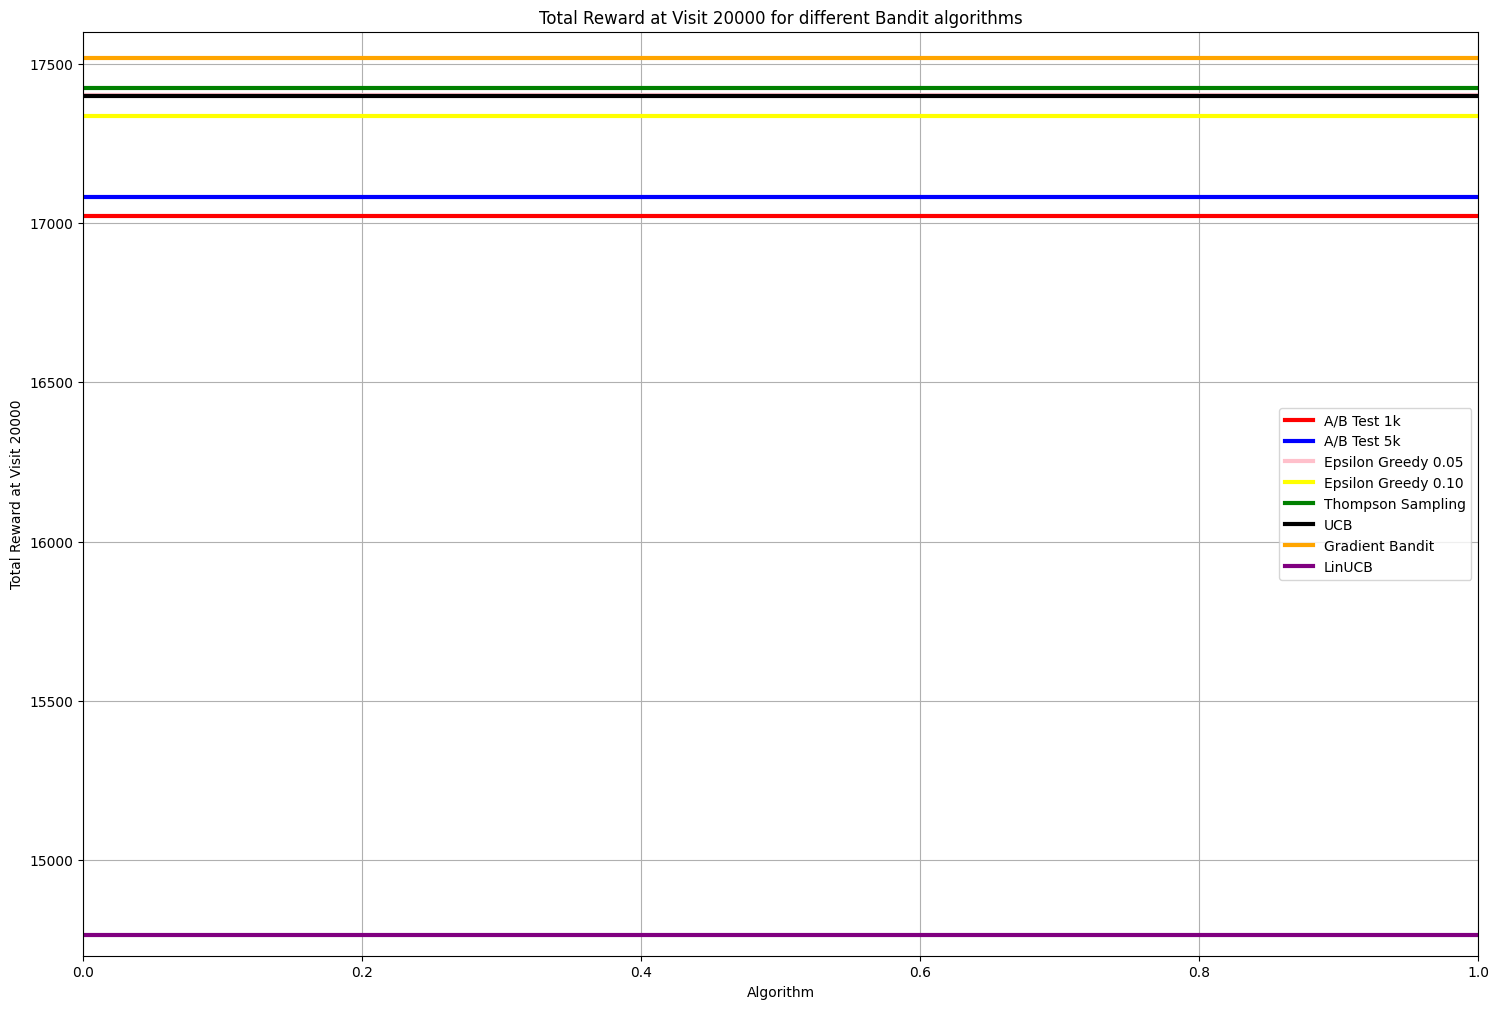

In [ ]:
plt.figure(figsize=(18, 12))  # Adjust figure size as needed

# Plotting horizontal lines for each algorithm
plt.axhline(y=ab_1k_avg_results_df.total_reward.iloc[19999], color='red', label='A/B Test 1k', linewidth=3)
plt.axhline(y=ab_5k_avg_results_df.total_reward.iloc[19999], color='blue', label='A/B Test 5k', linewidth=3)
plt.axhline(y=epsilon_05_avg_results_df.total_reward.iloc[19999], color='pink', label='Epsilon Greedy 0.05', linewidth=3)
plt.axhline(y=epsilon_10_avg_results_df.total_reward.iloc[19999], color='yellow', label='Epsilon Greedy 0.10', linewidth=3)
plt.axhline(y=thompson_avg_results_df.total_reward.iloc[19999], color='green', label='Thompson Sampling', linewidth=3)
plt.axhline(y=ucb_avg_results_df.total_reward.iloc[19999], color='black', label='UCB', linewidth=3)
plt.axhline(y=gradient_avg_results_df.total_reward.iloc[19999], color = 'orange', label='Gradient Bandit', linewidth=3)
plt.axhline(y=linUCB_avg_results_df.total_reward.iloc[19999], color = 'purple', label='LinUCB', linewidth=3)

plt.ylim(14700, 17600)

plt.xlabel("Algorithm")
plt.ylabel("Total Reward at Visit 20000")
plt.title("Total Reward at Visit 20000 for different Bandit algorithms")
plt.legend()
plt.grid(True)
plt.show()